# How to calibrate your neural network classifer:
## Getting accurate probabilities from your neural network model

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nplan-io/kdd2020-calibration/blob/master/tutorial/KDD%202020%20-%20nPlan%20calibration%20session.ipynb)

## 1. Introduction

In this tutorial we'll use the CIFAR-10 image dataset, and a classifier trained on it, to explore what model confidence calibration is, how we can measure it, and what methods we can put in place to rectify poorly calibrated models.

In [1]:
# import relevant modules
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import cifar10
import tensorflow.keras.utils
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
%matplotlib inline

/home/dan/venvs/venv1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dan/venvs/venv1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dan/venvs/venv1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dan/venvs/venv1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [2]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, shuffle=False)

#### CIFAR-10
CIFAR-10 is a dataset containing a collection of images falling into 10 classes: airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. It contains 60 000 low resolution (32x32) images and is often used to train ML and computer vision models. This is commonly divided into 50 000 training images and 10 000 testing images. The low resolution allows for quick testing of different models.

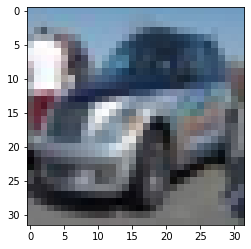

In [3]:
plt.imshow(x_train[112,])
plt.show()

First we need to do some preprocessing of the data. This will allow our model to achieve higher accuracy.

In [4]:
# Normalize data.
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean from each image
x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_val -= x_train_mean
x_test -= x_train_mean

# translate data to categorical
y_train_labels = y_train
y_val_labels = y_val
y_test_labels = y_test

y_train = tensorflow.keras.utils.to_categorical(y_train, 10)
y_val = tensorflow.keras.utils.to_categorical(y_val, 10)
y_test = tensorflow.keras.utils.to_categorical(y_test, 10)

#### The models
The obvious next step would be training a model but as we have limited time and resources, we will be using two pre-trained models:
- [Keras ResNet model](https://github.com/keras-team/keras/blob/master/examples/cifar10_resnet.py)
- [A binary simplification of this model - that tries to discriminate between dogs and cats!](fill_me)

In [5]:
# model = Model(<some layers>)
# ...
# model.fit(x_train, y_train)
# ...
# model.evaluate(x_test,y_test)
#

In [6]:
# download and load pretrained models
h5file = tensorflow.keras.utils.get_file('/tmp/KDD_model_1.h5',
         'https://raw.githubusercontent.com/nplan-io/kdd2020-calibration/master/tutorial/cifar10_resnet.h5')
multiclass_model = load_model(h5file)

h5file = tensorflow.keras.utils.get_file('/tmp/KDD_model_2.h5',
         'https://raw.githubusercontent.com/nplan-io/kdd2020-calibration/master/tutorial/cifar10_resnet_binary.h5')
binary_model = load_model(h5file)

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:
# manipulate the full data set to create a subset of images of cats (class 3)
# and dogs (class 5) to use with the binary classifier
x_val_binary = x_val[(y_val_labels==3).flatten()|(y_val_labels==5).flatten(),:,:]
x_test_binary =  x_test[(y_test_labels==3).flatten()|(y_test_labels==5).flatten(),:,:]

y_val_binary = y_val_labels[(y_val_labels==3).flatten()|(y_val_labels==5).flatten()]
y_test_binary = y_test_labels[(y_test_labels==3).flatten()|(y_test_labels==5).flatten()]

# our binary classifier will have target labels of 1 for cat and 0 for dog
y_val_binary = [1 if target == 3 else 0 for target in y_val_binary]
y_test_binary = [1 if target == 3 else 0 for target in y_test_binary]

In [8]:
y_pred_binary = binary_model.predict(x_val_binary)
acc_score = accuracy_score(y_val_binary, y_pred_binary>0.5)
loss_score = log_loss(y_val_binary, y_pred_binary)
print('Binary metrics: validation accuracy is {0:.2f}, validation loss is {1:.2f}'.format(acc_score, loss_score))

Binary metrics: validation accuracy is 0.79, validation loss is 0.84


In [9]:
y_pred = multiclass_model.predict(x_val)
acc_score = accuracy_score(np.argmax(y_val,1),np.argmax(y_pred,1))
loss_score = log_loss(y_val, y_pred)
print('Multiclass metrics: validation accuracy is {0:.2f}, validation loss is {1:.2f}'.format(acc_score, loss_score))

Multiclass metrics: validation accuracy is 0.91, validation loss is 0.34


## 2. Understanding and measuring calibration - binary problems

A lot of calibration concepts were devised in binary problems, so we'll explore them using our binary model first.

### 2.1 Reliability diagrams
Can you use `calibration_curve()` from scikit-learn to show how calibrated the model is on our data? Return two arrays, `prob_true_binary` and `prob_pred_binary`. How would you interpret the results?

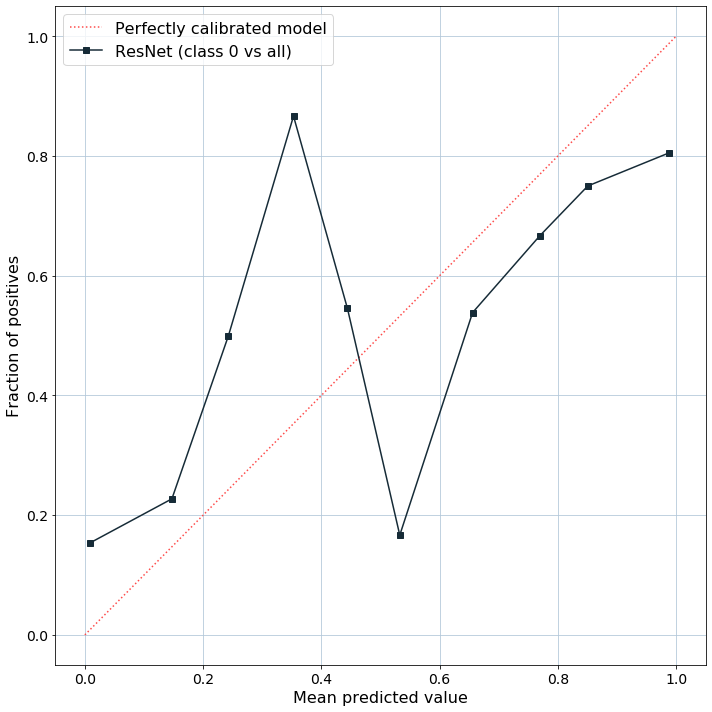

In [10]:
# calculate the values of calibration curve for bin 0 vs all
prob_true_binary, prob_pred_binary = calibration_curve(y_val_binary, y_pred_binary, n_bins=10)

# Plot the calibration curve for ResNet in comparison with what a perfectly calibrated model would look like
fig = plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], color="#FE4A49", linestyle=":", label="Perfectly calibrated model")
plt.plot(prob_pred_binary, prob_true_binary, "s-", label="ResNet (class 0 vs all)", color="#162B37")

plt.ylabel("Fraction of positives", fontsize=16)
plt.xlabel("Mean predicted value", fontsize=16)

plt.legend(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True, color="#B2C7D9")

plt.tight_layout()

### 2.2 Expected calibration error
Given the explanation of ECE, can you calculate the error for our dataset?

In [11]:
# complete this function to calculate ece
def ece_calculation_binary(prob_true, prob_pred, bin_sizes):
    ### YOUR CODE HERE
    ece = 0
    for m in np.arange(len(bin_sizes)):
        ece = ece + (bin_sizes[m] / sum(bin_sizes)) * np.abs(prob_true[m] - prob_pred[m])
    return ece

# print the calculated ece
n_bins_binary = len(prob_true_binary)
pred_hist = np.histogram(a=y_pred_binary, range=(0, 1), bins=n_bins_binary)[0]     
print(ece_calculation_binary(prob_true_binary, prob_pred_binary, pred_hist))

0.16650599497969484


### 2.3 Maximum calibration error
Given the explanation of MCE, can you calculate it for our model?

In [12]:
# complete this function to calculate mce
def mce_calculation_binary(prob_true, prob_pred, bin_sizes):
    ### YOUR CODE HERE 
    mce = 0
    for m in np.arange(len(bin_sizes)):
        mce = max(mce, np.abs(prob_true[m] - prob_pred[m]))
    return mce

#print the calculated mce
print(mce_calculation_binary(prob_true_binary, prob_pred_binary, pred_hist))

0.5137533108393352


### 2.4 Root mean square calibration error
Given the explanation, can you calculate RMSCE for our data?

In [13]:
# complete this function to calculate rmsce
def rmsce_calculation_binary(prob_true, prob_pred, bin_sizes):
    ### YOUR CODE HERE 
    rmsce = 0
    for m in np.arange(len(bin_sizes)):
        rmsce = rmsce + (bin_sizes[m] / sum(bin_sizes)) * (prob_true[m] - prob_pred[m]) ** 2
    return np.sqrt(rmsce)

# print the calculated rmsce
print(rmsce_calculation_binary(prob_true_binary, prob_pred_binary, pred_hist))

0.17508872544859896


## 3. Measuring calibration in multiclass problems
Extending the definition of these metrics, we can use them for multiclass classifiers, too. Considering each class seperately, can you show the reliability diagrams and calculate the calibration errors for the 10 class model? Can you combine them?

In [14]:
### YOUR CODE HERE


def ece_calculation_multiclass(y_true, y_pred):
    ### use calibration_curve and your binary function to complete this function
    ece_bin = []
    for a_class in range(y_true):
        prob_true, prob_pred = calibration_curve(y_true[a_class], y_pred[a_class])
        bin_sizes = np.histogram(a=y_pred[a_class], range=(0, 1), bins=n_bins_0)[0]
        ece_bin.append(ece_calculation_binary(prob_true, prob_pred, bin_sizes))
    ## here we have a choice - do we wish to weight our metric depending on the number
    ## of positive examples in each class, or take an unweighted mean
    
    # return sum(ece_bin*class_weights)/n_classes
    return mean(ece_bin)
        
    
def mce_calculation_multiclass(y_true, y_pred):
    ### use calibration_curve and your binary function to complete this function
    mce_bin = []
    for a_class in range(y_true):
        prob_true, prob_pred = calibration_curve(y_true[a_class], y_pred[a_class])
        bin_sizes = np.histogram(a=y_pred[a_class], range=(0, 1), bins=n_bins_0)[0]
        mce_bin.append(mce_calculation_binary(prob_true, prob_pred, bin_sizes))
    ## here we have a choice - do we wish to weight our metric depending on the number
    ## of positive examples in each class, or take an unweighted mean
    
    # return sum(ece_bin*class_weights)/n_classes
    return mean(mce_bin)
    
def rmsce_calculation_multiclass(y_true, y_pred):
    ### use calibration_curve and your binary function to complete this function
    rmsce_bin = []
    for a_class in range(y_true):
        prob_true, prob_pred = calibration_curve(y_true[a_class], y_pred[a_class])
        bin_sizes = np.histogram(a=y_pred[a_class], range=(0, 1), bins=n_bins_0)[0]
        rmsce_bin.append(rmsce_calculation_binary(prob_true, prob_pred, bin_sizes))
    ## here we have a choice - do we wish to weight our metric depending on the number
    ## of positive examples in each class, or take an unweighted mean
    
    # return sum(ece_bin*class_weights)/n_classes
    return mean(rmsce_bin)

## 4. Post-training calibration methods - binary problems
One way to mitigate a poorly calibrated model is through a post-hoc calibration method. In general, we seek a function to translate some output of our model into a calibrated probability. These come in several flavours - first we look at the binary problem, as before.

### 4.1 Non-parametric methods (Isotonic regression)
Given the description of isotonic regression, can you fit a stepwise constant, monotonically increasing function to the bucketed softmax data? Again, scikit-learn may be useful. Plot your result on the reliability diagram.

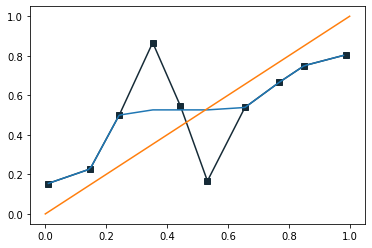

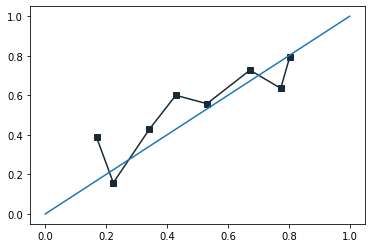

In [15]:
from sklearn.isotonic import IsotonicRegression
iso_reg = IsotonicRegression().fit(prob_pred_binary, prob_true_binary)

plt.plot(prob_pred_binary, prob_true_binary, "s-", label="ResNet (class 0 vs all)", color="#162B37")
a_grid = np.linspace(0, 1, 100)
plt.plot(a_grid, iso_reg.predict(a_grid))
plt.plot([0,1],[0,1])
plt.show()

#y_pred = model.predict(x_test)
y_pred_corr = iso_reg.predict(y_pred_binary.flatten())

prob_true_binary_corr, prob_pred_binary_corr = calibration_curve(y_val_binary, y_pred_corr, n_bins=10)

plt.plot(prob_pred_binary_corr, prob_true_binary_corr, "s-", label="ResNet (class 0 vs all)", color="#162B37")
plt.plot([0,1],[0,1])
plt.show()

### 4.2 Platt scaling
Now, based on the explanation, can you implement binary platt scaling for our binary classifier?

[Hint - you do not necessarily need to rerun the model, and can run `scipy.special.logit()` on `y_pred_binary` to return the vector of logits]

How did it improve the calibration? 

In [16]:
from scipy.optimize import minimize
from scipy.special import logit, expit

y_pred_binary = binary_model.predict(x_val_binary)

y_logits = logit(y_pred_binary)
def scale_fun_bce(x, *args):
    a, b = x
    y_logit_scaled = a*y_logits + b
    y_pred_inner = expit(y_logit_scaled)
    bce = sum([-(y_t * np.log(y_p) + (1 - y_t) * np.log(1 - y_p)) for y_t, y_p in zip(y_val_binary[:1000], y_pred_inner) if not y_p==0])
    return bce

min_obj = minimize(scale_fun_bce,[1,0], method='Nelder-Mead',options={'xatol': 1e-8, 'disp': True})
min_obj

/home/dan/venvs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


Optimization terminated successfully.
         Current function value: 440.296997
         Iterations: 53
         Function evaluations: 117


 final_simplex: (array([[0.27955883, 0.00080822],
       [0.27955883, 0.00080821],
       [0.27955884, 0.00080821]]), array([440.29699707, 440.29699707, 440.29699707]))
           fun: 440.2969970703125
       message: 'Optimization terminated successfully.'
          nfev: 117
           nit: 53
        status: 0
       success: True
             x: array([0.27955883, 0.00080822])

## 5 Calibrating multiclass models

Extending to the multiclass case is not simple. Several methods have been suggested, which include treating each class as a one-vs-all binary problem, calibrating it, and then normalising the new calibrated values across classes. Another idea is to generalise Platt Scaling from a one-dimensional linear optimisation problem - we will discuss this below.

### 5.1 Keras example -  temperature scaling
A very simple generalisation of Platt scaling is to tune a single parameter based on the logits of the network, in order to try to optimise NLL - this is temperature scaling.

First we need to define a Keras layer that does the transformation we want:

In [17]:
import tensorflow as tf
class TemperatureLayer(tensorflow.keras.layers.Layer):
    """
    A keras layer that divides the input tensor elementwise by a single trainable parameter
    temp_weight
    """
    def __init__(self, **kwargs):
        """
        Initialises layer with weight param
        """
        self.temp_weight = None
        super(TemperatureLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        """
        Defines the trainable parameters of the model
        """
        self.temp_weight = self.add_weight(
            name="temp",
            shape=(1,),
            initializer='one'
        )
        super(TemperatureLayer, self).build(input_shape)
        
    def call(self, in_tensor):
        """
        Divide input tensor by constant t
        """
        return tf.divide(in_tensor, self.temp_weight)

Now we can take our trained model and insert the temperature layer prior to the softmax output:

In [18]:
new_model = multiclass_model
# remove the original softmax
new_model.layers.pop()
# pipe the intermediate output through our new layer
output = new_model.layers[-1].output
output = TemperatureLayer(name="calibration", trainable=False)(output)
# add the softmax again
output = tf.keras.layers.Activation('softmax', name='new_softmax')(output)
# rebuild the model
new_model = tf.keras.Model(inputs=new_model.input, outputs=output)

In [19]:
# we can see when we  that we've inserted the layer into the model
new_model.layers[-5:]

Now we need to fix our pretrained weights, allow the calibration weights to be trained, and recompile the model:

In [20]:
for layer in new_model.layers:
    if "calibration" in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

new_model.compile(optimizer="Adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

We can now train the model using Keras `model.fit` - and only our calibration layer weights will be trained!

In [ ]:
new_model.fit(x_val,y_val)

3200/5000 [==================>...........] - ETA: 3s - loss: 1.6458 - acc: 0.9122

In [ ]:
# plot the reliability diagrams and use your metric calculators to calculate the calibration metrics for this new model
# have they improved?


### 5.2 Implementing a scaling layer
Now it's your turn. Implement and evaluate a calibration method on the multiclass classifier. Based on the explanations you can use either matrix or vector platt layer. 

In [ ]:
### Complete this class to encapsulate the vector or matrix scaling logic as explained in the presentation

# (hint - keras.layers.Dense may help for matrix platt!)

### This is an implementation of the vector scaling layer:
class MyCalLayer(tf.keras.layers.Layer):
    """ A template keras layer """
    
    def __init__(self, **kwargs):
        """ Initialises layer with weight params """
        ###
        # initialise weight variables here
        ###
        
        # we need two vectors:
        self.weight_vector = None
        self.bias_vector = None
        super(MyCalLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        """ Defines the trainable parameters of the model """
        ###
        # add keras weight objs of the correct shape to
        # the respective varibles here
        ###
        
        # use the add_weight method to add a keras weight - 
        # they should be tensors of the same size as the input
        self.weight_vector = self.add_weight(
            name="platt_weight",
            shape=(input_shape[1],),
            initializer='one'
        )
        self.bias_vector = self.add_weight(
            name="platt_bias",
            shape=(input_shape[1],),
            initializer='zero'
        )
        super(MyCalLayer, self).build(input_shape)
        
    def call(self, in_tensor):
        """ undertakes layer transformation """
        ###
        # use the relevant tf functions to manipulate 
        # tensors as required, and return result
        ###
        
        # we want to carry out a dot product and an addition:
        # this is how we do so in tf
        return tf.multiply(in_tensor, self.weight_vector) + self.bias_vector

In [ ]:
# follow the steps of the temperature scaling example above to calibrate and evaluate your model
